# Solutions for Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-8-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

## Overlap-Add

In [2]:
def nextPowerOf2(L):
    '''
    Calculates the smallest power of 2 which is bigger than input variable n
    
    This helper function can be used to calculate an appropriate 
    length for an DFT which is longer than the signal length n and a power of 2.
    
    Input:
        L: int
            signal length
    Output:
        p: integer which is greater or equal than n and a power of 2
    
    Examples:
        for L in range(20):
            print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))
            
        x=ones(11)
        L_FFT=nextPowerOf2(len(x))
    '''
    if (L<2):
        return 2
    # If n is a power of 2 then return n 
    if (L and not(L & (L - 1))):
        return L
    # If n is NOT a power of 2 
    p = 1
    while (p < L) :
        p <<= 1 
    return p

def nextPowerOf2_simple(L):
    return int(np.max([2,2**np.ceil(np.log2(L))]))

In [5]:
for L in range(20):
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L))) 
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2_simple(L)))


# Get smallest power of 2 at least as large as N
NFFT = 2 ** np.ceil(math.log2(N))

nextPowerOf2(L) for L=0 is 2
nextPowerOf2(L) for L=0 is 2
nextPowerOf2(L) for L=1 is 2
nextPowerOf2(L) for L=1 is 2
nextPowerOf2(L) for L=2 is 2
nextPowerOf2(L) for L=2 is 2
nextPowerOf2(L) for L=3 is 4
nextPowerOf2(L) for L=3 is 4
nextPowerOf2(L) for L=4 is 4
nextPowerOf2(L) for L=4 is 4
nextPowerOf2(L) for L=5 is 8
nextPowerOf2(L) for L=5 is 8
nextPowerOf2(L) for L=6 is 8
nextPowerOf2(L) for L=6 is 8
nextPowerOf2(L) for L=7 is 8
nextPowerOf2(L) for L=7 is 8
nextPowerOf2(L) for L=8 is 8
nextPowerOf2(L) for L=8 is 8
nextPowerOf2(L) for L=9 is 16
nextPowerOf2(L) for L=9 is 16
nextPowerOf2(L) for L=10 is 16
nextPowerOf2(L) for L=10 is 16
nextPowerOf2(L) for L=11 is 16
nextPowerOf2(L) for L=11 is 16
nextPowerOf2(L) for L=12 is 16
nextPowerOf2(L) for L=12 is 16
nextPowerOf2(L) for L=13 is 16
nextPowerOf2(L) for L=13 is 16
nextPowerOf2(L) for L=14 is 16
nextPowerOf2(L) for L=14 is 16
nextPowerOf2(L) for L=15 is 16
nextPowerOf2(L) for L=15 is 16
nextPowerOf2(L) for L=16 is 16
nextPowerOf2(L)

C:\Users\stefan\AppData\Local\Temp/ipykernel_13820/2620285668.py:33: RuntimeWarning: divide by zero encountered in log2
  return int(np.max([2,2**np.ceil(np.log2(L))]))


NameError: name 'math' is not defined

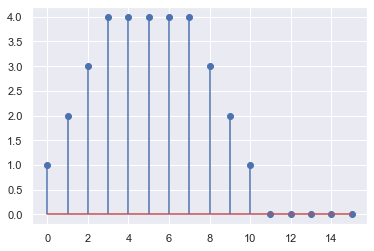

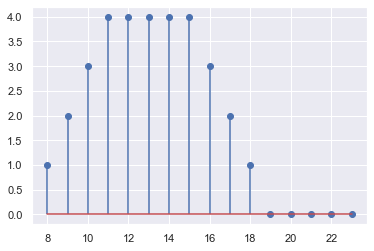

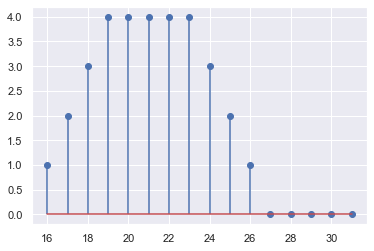

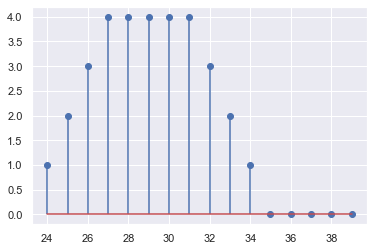

In [6]:
L_x = 32
L_h = 4
x=np.ones(L_x)
h=np.ones(L_h)

L_Bl  = 8   # block length (see Fig 2.25 in https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Ch2.S3.html)
L_hop = 8
L_DFT = nextPowerOf2(L_Bl+L_h-1)
# L_DFT = 16

noOfFrames = (L_x // L_hop) # number of blocks

# outer loop over mic channels
# h = np.zeros(L_DFT)
# h[:L_h] = h
H = np.fft.rfft(h, n=L_DFT)
oldBlock = []
for iFrame in range(noOfFrames):
    #x_block = np.zeros(L_DFT) # zero padding # not needed
    k = np.arange(iFrame*L_hop, iFrame*L_hop+L_Bl) # time vector
    x_block = x[k]
    # k = np.hstack((k,np.zeros(L_DFT-len(k))))  # zero padding
    X_block = np.fft.rfft(x_block, n=L_DFT)

    Y = X_block*H # frequency domain multiplication
    y = np.fft.irfft(Y, n=L_DFT)

    k2 = np.arange(iFrame*L_hop, iFrame*L_hop+L_DFT) # time vector
    plt.figure()
    plt.stem(k2,y)

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 